In [1]:
# Importing required libraries

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Setting up path to data file

In [3]:

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the parent directory
parent_dir = os.path.dirname(current_dir)

# Construct the path to the 'Cycling Analysis' directory and then to the 'data' directory within it
cycling_data_dir = os.path.join(parent_dir, 'Cycling Analysis', 'data')

# Construct the full path to the 'extended_activities.csv' file
extended_activities_path = os.path.join(cycling_data_dir, 'extended_activities.csv')


In this document, we will perform two main tasks:

1. Simulating VO2 Max values for Running and Ride activities. 
2. Create a predictive model to predict future value of VO2 Max for athlete. 

To acomplish this, we will walk through the methodology to simulate values and data processing.

#### A. Values simulating methodology
The simulation is based on established protocols from an article of Sport Coaching NZ, which explains the computation methods used by devices like Garmin.

Link to the article: https://sportcoaching.co.nz/how-does-garmin-calculate-vo2-max/

The VO2 max for Running and Cycling activities is estimated using the following formulas:

- **Running on a Level Ground**: Theoretical VO2 (ml/kg/min) $= 3.5 \times \text{speed}$
- **Cycling**: Theoretical VO2 (ml/kg/min) $= \frac{12.35 \times \text{Power} + 300}{\text{person's weight}}$

Theoretical V02 calculation for some other activities listed in the article:

- **Walking and Pole Walking**: Theoretical VO2 (ml/kg/min) $= 1.78 \times \text{speed} \times 16.67[\tan(\text{inclination}) + 0.073]$
- **Running in a Hilly Terrain**: Theoretical VO2 (ml/kg/min) $= 3.33 \times \text{speed} + 15 \times \tan(\text{inclination}) \times \text{speed} + 3.5$
- **Rowing (Indoor)**: Theoretical VO2 (ml/kg/min) $= \frac{14.72 \times \text{Power} + 250.39}{\text{person’s weight}}$

*Unit of speed = kilometers per hour (km/h).*<br>
*Unit of inclination = degrees(°).*<br>
*Unit of power = watts (W).*<br>
*Unit of weight = kilograms (kg).*<br>

#### B. Data processing

- Data processing will follow the precedents set by the extensive exploratory data analysis (EDA) of the running dataset.
- A structured approach to data integrity includes:
    - Handling Missing Values:
        - Variables missing more than 50% of their data will be dropped to maintain dataset integrity.
        - Variables missing less than 50% of their data will have missing values imputed with the median of the available data.
        
**Athlete Weight Consideration:**

As we see in the simulation methodology for the VO2 max values for Cycling activities, `Athelete weight` is a crucial variable. Therefore, to ensure the column is not removed from the data, we will apply the computed median to the NaN values before processing them as in step 1. 

In [4]:
# Use the path to load the data
activities_data = pd.read_csv(extended_activities_path)

# Sneak peak of the data
print(activities_data.head(10))

   Activity ID          Activity Date   Activity Name Activity Type  \
0   2929442069  13 Dec 2019, 01:46:07      Lunch Ride          Ride   
1   2945780637  20 Dec 2019, 23:05:01    Morning Ride          Ride   
2   2948028275  21 Dec 2019, 23:25:29    Morning Ride          Ride   
3   2952462113  24 Dec 2019, 01:19:17      Lunch Ride          Ride   
4   2956494096  26 Dec 2019, 00:09:08      Lunch Ride          Ride   
5   2961293151  27 Dec 2019, 23:38:08    Morning Ride          Ride   
6   2969244332  31 Dec 2019, 01:48:12      Lunch Ride          Ride   
7   2974544942   2 Jan 2020, 03:43:00  Afternoon Ride          Ride   
8   2979711652   3 Jan 2020, 23:27:55    Morning Ride          Ride   
9   2982905280   5 Jan 2020, 01:30:44      Lunch Ride          Ride   

   Elapsed Time  Distance  Max Heart Rate  Relative Effort  Commute  \
0          3859     22.97           139.0             11.0    False   
1          4852     29.65           133.0             12.0    False   
2    

In [5]:
# Handle missing values in 'Athlete weight' variable

# Compute the median weight, excluding NaN values
median_weight = activities_data['Athlete Weight'].median()
    
# Fill NaN values in 'Athlete weight' with the computed median
activities_data['Athlete Weight'].fillna(median_weight, inplace=True)


In [6]:
activities_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Activity ID                345 non-null    int64  
 1   Activity Date              345 non-null    object 
 2   Activity Name              345 non-null    object 
 3   Activity Type              345 non-null    object 
 4   Elapsed Time               345 non-null    int64  
 5   Distance                   345 non-null    float64
 6   Max Heart Rate             345 non-null    float64
 7   Relative Effort            345 non-null    float64
 8   Commute                    345 non-null    bool   
 9   Activity Gear              162 non-null    object 
 10  Filename                   345 non-null    object 
 11  Athlete Weight             345 non-null    float64
 12  Bike Weight                162 non-null    float64
 13  Moving Time                345 non-null    float64

In [7]:
# Data summary
activities_data.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Moving Time,Max Speed,Average Speed,...,Maximum Power 10s,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr
count,3.450000e+02,345.000000,345.000000,345.000000,345.000000,345.000000,162.0,345.000000,345.000000,345.000000,...,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,6.902344e+09,5979.898551,34.531594,160.881159,90.675362,80.046377,8.0,5756.182609,9.384317,5.409151,...,325.342899,277.945217,256.211594,226.977391,219.397101,213.540870,208.779130,149.720000,94.603768,44.874783
std,2.216048e+09,3386.451360,29.416878,20.664550,96.468992,0.428823,0.0,3212.340525,5.358274,2.395178,...,58.746424,41.920679,38.860312,43.435546,45.371032,45.956143,48.554844,92.424956,94.613402,79.101485
min,2.929442e+09,1506.000000,4.060000,118.000000,5.000000,80.000000,8.0,1506.000000,3.233984,2.696547,...,158.000000,157.100000,156.600000,127.600000,119.000000,115.300000,0.000000,0.000000,0.000000,0.000000
25%,3.758711e+09,3646.000000,12.150000,142.000000,25.000000,80.000000,8.0,3589.000000,4.600000,2.986536,...,290.200000,254.800000,230.100000,191.500000,181.900000,174.600000,170.300000,112.300000,0.000000,0.000000
50%,7.882339e+09,5583.000000,24.280000,160.000000,51.000000,80.000000,8.0,5472.000000,10.100000,6.111000,...,322.000000,283.400000,262.400000,237.500000,233.600000,229.200000,216.600000,168.400000,121.200000,0.000000
75%,8.334993e+09,7338.000000,52.230000,178.000000,127.000000,80.000000,8.0,7153.000000,12.438001,7.582000,...,352.300000,303.900000,282.400000,262.300000,256.700000,251.200000,248.500000,235.300000,172.900000,123.300000
max,1.027158e+10,22391.000000,180.080000,210.000000,528.000000,84.000000,8.0,21208.000000,45.083332,10.652900,...,637.400000,407.500000,342.800000,323.300000,319.300000,315.700000,301.500000,289.800000,287.600000,272.100000


#### Missing values


In [8]:
# Sum the total rows of missing values from each attribute
missing_values = activities_data.isnull().sum()

# Return only attrbutes with missing values
missing_values[missing_values > 0]

Activity Gear                183
Bike Weight                  183
Elevation Gain                 1
Elevation Loss                 7
Elevation Low                  7
Elevation High                 7
Average Temperature          161
Total Work                   148
Perceived Exertion           344
Prefer Perceived Exertion    343
Perceived Relative Effort    344
Grade Adjusted Distance      182
Average Elapsed Speed         89
Dirt Distance                 89
Total Steps                  337
dtype: int64

**Handle attributes with more than 50% null values**

In [9]:
# Remove attributes where 50% or more data is missing
null_threshold = len(activities_data) * 0.5
activities_clean = activities_data.dropna(thresh=null_threshold, axis=1)

**Handle attributes with less than 50% null values**

In [10]:
# Columns containing missing val less than 50% of attribute
missing_val_cols = activities_clean.columns[(activities_clean.isnull().mean() > 0) & (activities_clean.isnull().mean() < 0.5)].tolist()

imputer = SimpleImputer(strategy='median')
activities_clean[missing_val_cols] = imputer.fit_transform(activities_clean[missing_val_cols])

activities_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Activity ID             345 non-null    int64  
 1   Activity Date           345 non-null    object 
 2   Activity Name           345 non-null    object 
 3   Activity Type           345 non-null    object 
 4   Elapsed Time            345 non-null    int64  
 5   Distance                345 non-null    float64
 6   Max Heart Rate          345 non-null    float64
 7   Relative Effort         345 non-null    float64
 8   Commute                 345 non-null    bool   
 9   Filename                345 non-null    object 
 10  Athlete Weight          345 non-null    float64
 11  Moving Time             345 non-null    float64
 12  Max Speed               345 non-null    float64
 13  Average Speed           345 non-null    float64
 14  Elevation Gain          345 non-null    fl

#### VO2 Max values simulation

In [11]:
# Convert speed from m/s to km/h for the calculation (1 m/s = 3.6 km/h)
activities_clean['Average Speed km/h'] = activities_clean['Average Speed'] * 3.6

# Define the function to calculate VO2 max based on available activity data
def calculate_vo2_max(row):
    activity_type = row['Activity Type'].lower()  
    weight = row['Athlete Weight']
    
    # Defaults if data is missing
    speed = row.get('Average Speed km/h', 0) or 0
    power = row.get('Weighted Average Power', 0) or 0 
    inclination = 0  # Assume flat if not available or applicable
    
    if 'ride' in activity_type or 'cycling' in activity_type:
        return (12.35 * power + 300) / weight
    elif 'run' in activity_type and 'hilly' in activity_type:
        return 3.33 * speed + 15 * np.tan(np.radians(inclination)) * speed + 3.5
    elif 'run' in activity_type:
        return 3.5 * speed
    elif 'walk' in activity_type:
        return 1.78 * speed * 16.67 * (np.tan(np.radians(inclination)) + 0.073)
    elif 'rowing' in activity_type:
        return (14.72 * power + 250.39) / weight
    return np.nan  # EDA step skipped

# Apply the function to each row to calculate the VO2 max
activities_clean['VO2 Max'] = activities_clean.apply(calculate_vo2_max, axis=1)

# Save or display the results
print(activities_clean.head())
activities_clean.to_csv('simu_vo2_activities.csv', index=False)

   Activity ID          Activity Date Activity Name Activity Type  \
0   2929442069  13 Dec 2019, 01:46:07    Lunch Ride          Ride   
1   2945780637  20 Dec 2019, 23:05:01  Morning Ride          Ride   
2   2948028275  21 Dec 2019, 23:25:29  Morning Ride          Ride   
3   2952462113  24 Dec 2019, 01:19:17    Lunch Ride          Ride   
4   2956494096  26 Dec 2019, 00:09:08    Lunch Ride          Ride   

   Elapsed Time  Distance  Max Heart Rate  Relative Effort  Commute  \
0          3859     22.97           139.0             11.0    False   
1          4852     29.65           133.0             12.0    False   
2          5817     32.38           139.0             19.0    False   
3          3851     21.68           140.0             11.0    False   
4          5843     32.36           131.0             14.0    False   

                       Filename  ...  Maximum Power 1.0min  \
0  activities/3117764808.csv.gz  ...                 221.2   
1  activities/3136634767.csv.gz  .

In [12]:
# Load the simulated data
df_simulated = pd.read_csv('simu_vo2_activities.csv')

# Separate the file into two different Activity Type dataframes
ride_activities = df_simulated[df_simulated['Activity Type'] == 'Ride']
run_activities = df_simulated[df_simulated['Activity Type'] == 'Run']

run_vo2 = run_activities['VO2 Max']
ride_vo2 = ride_activities['VO2 Max']


#### Running data

In [13]:
# Summary of simulated values
summary_stats = run_vo2.describe()
print(summary_stats)


count    164.000000
mean      37.562164
std        1.708170
min       33.976493
25%       36.482954
50%       37.551946
75%       38.529047
max       45.311225
Name: VO2 Max, dtype: float64


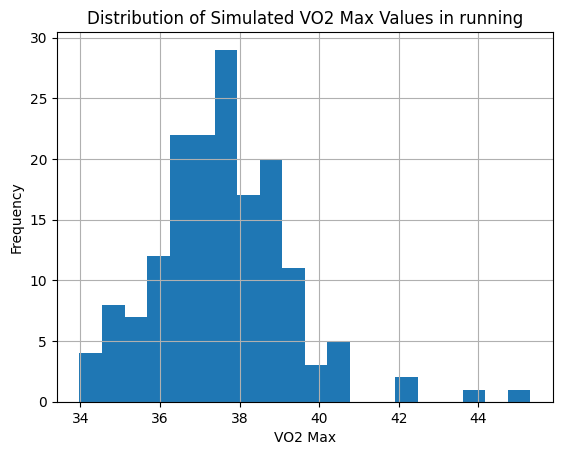

In [14]:
# Distribution of simulated values
import matplotlib.pyplot as plt

run_vo2.hist(bins=20)
plt.title('Distribution of Simulated VO2 Max Values in running')
plt.xlabel('VO2 Max')
plt.ylabel('Frequency')
plt.show()


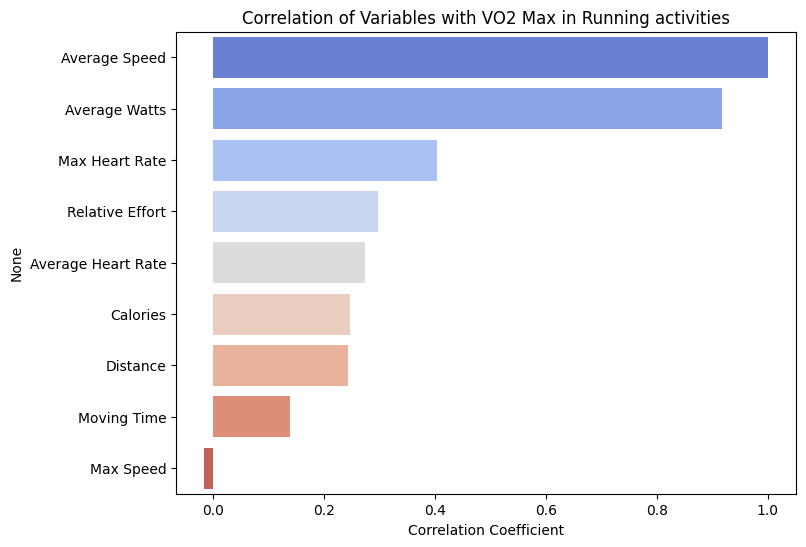

In [15]:
# Correlation matrix
# Selecting relevant columns
columns = ['Max Heart Rate', 'Average Heart Rate', 'Relative Effort', 'Moving Time',
           'Max Speed', 'Average Speed', 'Distance', 'Average Watts', 'Calories', 'VO2 Max']
data_selected_run = run_activities[columns]

# Calculate the correlation with VO2 Max
corr_with_vo2max = data_selected_run.corr()['VO2 Max'].sort_values(ascending=False)

# Drop the self-correlation of VO2 Max
corr_with_vo2max = corr_with_vo2max.drop('VO2 Max')

# Visualizing the correlation with VO2 Max
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_vo2max.values, y=corr_with_vo2max.index, palette='coolwarm')
plt.title('Correlation of Variables with VO2 Max in Running activities')
plt.xlabel('Correlation Coefficient')
plt.show()

#### Cycling data

In [16]:
# Summary of simulated values
summary_stats = ride_vo2.describe()
print(summary_stats)


count    181.000000
mean      28.531994
std        3.776591
min       20.576875
25%       25.980000
50%       28.450000
75%       30.765625
max       40.800000
Name: VO2 Max, dtype: float64


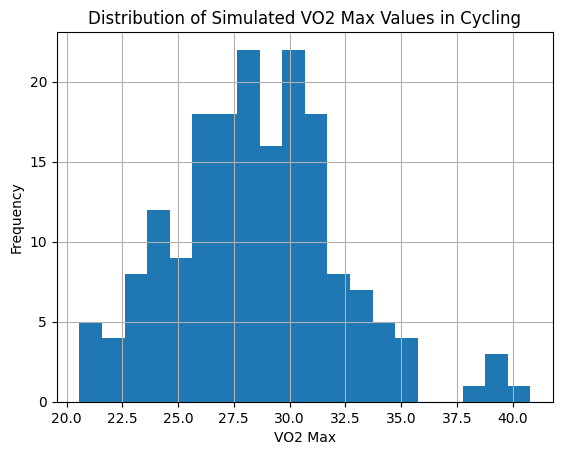

In [17]:
# Distribution of simulated values
import matplotlib.pyplot as plt

ride_vo2.hist(bins=20)
plt.title('Distribution of Simulated VO2 Max Values in Cycling')
plt.xlabel('VO2 Max')
plt.ylabel('Frequency')
plt.show()


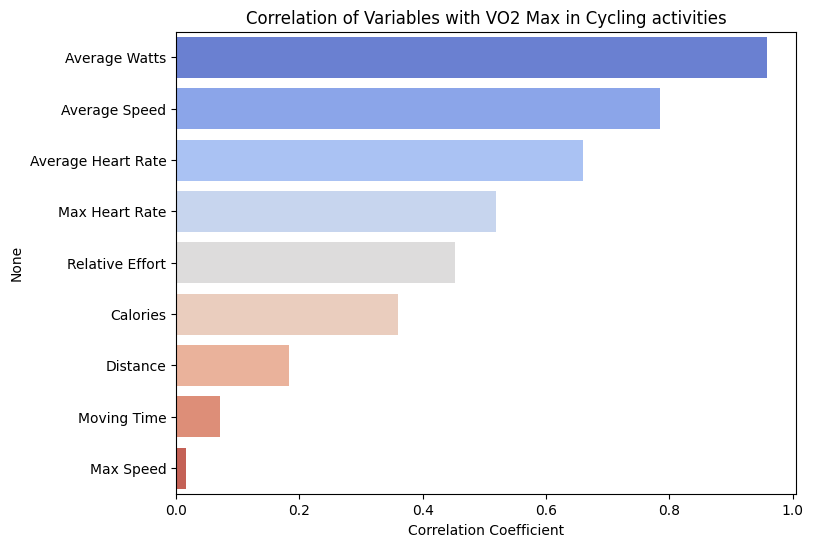

In [18]:
# Correlation matrix
# Selecting relevant columns
columns = ['Max Heart Rate', 'Average Heart Rate', 'Relative Effort', 'Moving Time',
           'Max Speed', 'Average Speed', 'Distance', 'Average Watts', 'Calories', 'VO2 Max']
data_selected_ride = ride_activities[columns]

# Calculate the correlation with VO2 Max
corr_with_vo2max = data_selected_ride.corr()['VO2 Max'].sort_values(ascending=False)

# Drop the self-correlation of VO2 Max
corr_with_vo2max = corr_with_vo2max.drop('VO2 Max')

# Visualizing the correlation with VO2 Max
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_vo2max.values, y=corr_with_vo2max.index, palette='coolwarm')
plt.title('Correlation of Variables with VO2 Max in Cycling activities')
plt.xlabel('Correlation Coefficient')
plt.show()

- Both running and cycling activities show that Average Speed is a strong predictor of VO2 Max, indicating that the ability to maintain higher speeds is closely linked to oxygen capacity. 
- In cycling, Average Watts, a measure of power output, has a significant strong correlation with VO2 Max, indicating the importance of intense exercises in cycling performance. 
- Max Heart Rate and Relative Effort are positively correlated with VO2 Max in both activities, suggesting the relation between oxygen capacity and cardiovascular strength and how hard the person is working relative to their fitness level. 
- Max Speed shows a very weak negative correlation in running and insignificant positvie correlation in cycling, might suggest that peak speed doesn't align with peak oxygen capacity of the athlete.

#### Predictive model for running activities

In [19]:
# Predictive modeling for running

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the data
X = data_selected_run.drop('VO2 Max', axis=1)
y = data_selected_run['VO2 Max']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.040178727770741114
R² Score: 0.9897015341169245


In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Data split
X = data_selected_run.drop('VO2 Max', axis=1)
y = data_selected_run['VO2 Max']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train_scaled, y_train)

# Model Evaluation

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

# Predict on the test set
y_pred = rf.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Cross-Validation Scores: [0.99707103 0.99562146 0.99539662 0.83162376 0.96245564]
Mean CV Score: 0.9564337002314623
Mean Squared Error: 0.04061044291167002
Root Mean Squared Error: 0.20152032878017548
R-squared: 0.9895908784566599


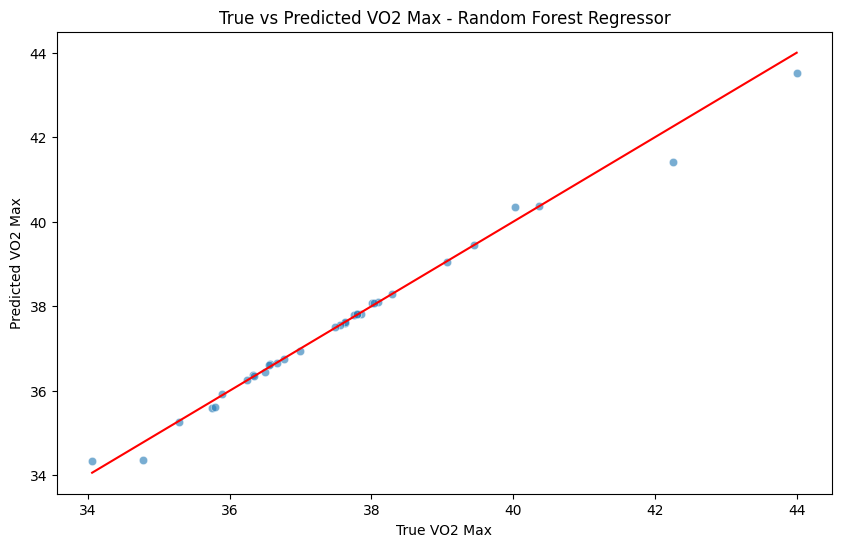

In [21]:
# Visualization

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x= y_test, y= y_pred, alpha=0.6)
sns.lineplot(x= y_test, y= y_test, color='red')
plt.xlabel('True VO2 Max')
plt.ylabel('Predicted VO2 Max')
plt.title('True vs Predicted VO2 Max - Random Forest Regressor')
plt.show()


#### Reducing dimenstionality by feature selection

In [22]:
# Importing required libraries for feature scoring
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

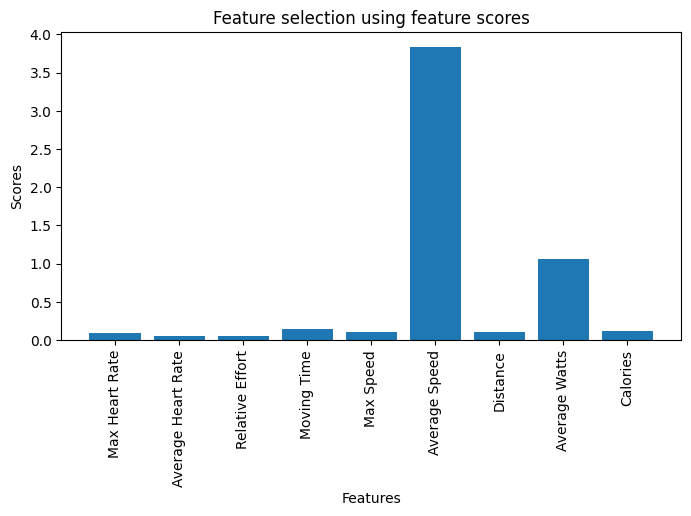

In [23]:
# Performing feature selection for all kept columns
# Using mutual_info_regression as scoring method
selector  = SelectKBest(score_func=mutual_info_regression, k="all")
X_selected = selector.fit_transform(X, y)

# Getting the selected feature indices
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

# Getting the feature scores
scores = selector.scores_

# Plotting the feature scores
plt.figure(figsize=(8, 4))
plt.bar(range(len(X.columns)), scores, tick_label=X.columns)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature selection using feature scores')
plt.show()

- Based on the applied feature scoring method 'Average Speed' and 'Average Watts' fields will be used for predictive modelling.

In [24]:
# Based on feature selection only Average Speed and Average Watts are used as input variables.
# "X_min" refers to reduced input variables.
X_min = data_selected_run[['Average Speed', 'Average Watts']]

# Checking reduced input dataset.
X_min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 89 to 344
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Average Speed  164 non-null    float64
 1   Average Watts  164 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB


In [25]:
# Splitting the dataset into training and testing sets
X_min_train, X_min_test, y_train, y_test = train_test_split(X_min, y, test_size=0.2, random_state=42)

In [26]:
# Checking the prediction accuracy of reduced input variables, with Randrom Forest Regressor used previously with all numerical columns
# Training a Random Forest Regressor with reduced input variables
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF.fit(X_min_train, y_train)

# Predicting and evaluating the model
y_pred_RF = model_RF.predict(X_min_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred_RF))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred_RF)))
print("R² Score:", r2_score(y_test, y_pred_RF))

Mean Squared Error: 0.04226794862441693
Root Mean Squared Error: 0.2055917036857687
R² Score: 0.9891660325996401


- The prediction accuracy using reduced input variables shows negligable accuracy loss when compared to previously used, same predictive model having all numerical fields.

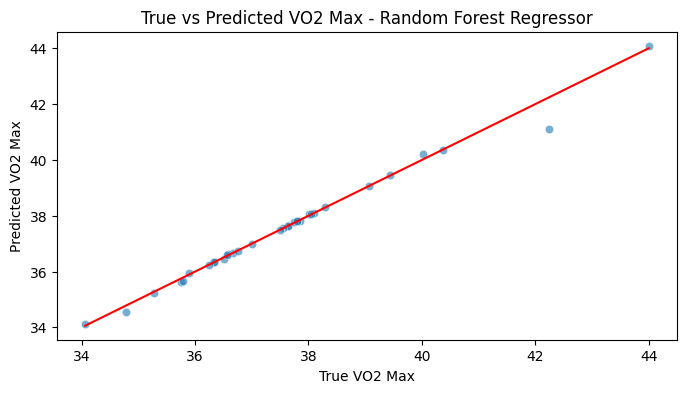

In [27]:
# Visualization
# Plotting the true vs predicted values for model using Random Forest Regressor
plt.figure(figsize=(8, 4))
sns.scatterplot(x= y_test, y= y_pred_RF, alpha=0.6)
sns.lineplot(x= y_test, y= y_test, color='red')
plt.xlabel('True VO2 Max')
plt.ylabel('Predicted VO2 Max')
plt.title('True vs Predicted VO2 Max - Random Forest Regressor')
plt.show()

- Besides the above tested Random Forest Regressor further machine learning methods will be created for testing purposes.
- The applied methods are Decision Tree Regressor, Gradient Boosting Regressor and Support Vector Regressor.

In [28]:
from sklearn.tree import DecisionTreeRegressor

# Setting up predictive model using Decision Tree Regressor with reduced input variables
model_DTR = DecisionTreeRegressor(criterion='squared_error', splitter='best', random_state=42)
model_DTR.fit(X_min_train, y_train)

# Predict on the testing set
y_pred_DTR= model_DTR.predict(X_min_test)

# Evaluate the model
mse_DTR = mean_squared_error(y_test, y_pred_DTR)
rmse_DTR = np.sqrt(mse_DTR)
r2_DTR = r2_score(y_test, y_pred_DTR)

print(f'Mean Squared Error: {mse_DTR}')
print(f'Root Mean Squared Error: {rmse_DTR}')
print(f'R-Squared: {r2_DTR}')

Mean Squared Error: 0.14533487668268497
Root Mean Squared Error: 0.38122811633283943
R-Squared: 0.9627482911435647


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

# Setting up predictive model using Gradient Boosting Regression with reduced input variables
model_GBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.5, random_state=42)
model_GBR.fit(X_min_train, y_train)

# Predict on the testing set
y_pred_GBR= model_GBR.predict(X_min_test)

# Evaluate the model
mse_GBR = mean_squared_error(y_test, y_pred_GBR)
rmse_GBR = np.sqrt(mse_GBR)
r2_GBR = r2_score(y_test, y_pred_GBR)

print(f'Mean Squared Error: {mse_GBR}')
print(f'Root Mean Squared Error: {rmse_GBR}')
print(f'R-Squared: {r2_GBR}')

Mean Squared Error: 0.1415043521420896
Root Mean Squared Error: 0.37617064231820324
R-Squared: 0.9637301173109013


In [30]:
from sklearn.svm import SVR

# Setting up predictive model using Support Vector Regressor with reduced input variables
model_SVR = SVR(kernel="linear", C=50, gamma="scale")
model_SVR.fit(X_min_train, y_train)

# Predict on the testing set
y_pred_SVR= model_SVR.predict(X_min_test)

# Evaluate the model
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mse_SVR)
r2_SVR = r2_score(y_test, y_pred_SVR)

print(f'Mean Squared Error: {mse_SVR}')
print(f'Root Mean Squared Error: {rmse_SVR}')
print(f'R-Squared: {r2_SVR}')

Mean Squared Error: 0.04208475568366554
Root Mean Squared Error: 0.2051456937975193
R-Squared: 0.9892129879502702


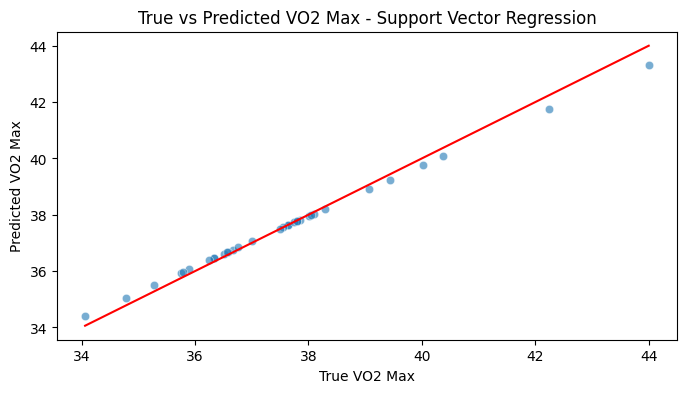

In [31]:
# The Support Vector Regression model shows high accuracy, comparable with the Random Forest Regression.

# Plotting the true vs predicted values for predictive model using Support Vector Regression
plt.figure(figsize=(8, 4))
sns.scatterplot(x= y_test, y= y_pred_SVR, alpha=0.6)
sns.lineplot(x= y_test, y= y_test, color='red')
plt.xlabel('True VO2 Max')
plt.ylabel('Predicted VO2 Max')
plt.title('True vs Predicted VO2 Max - Support Vector Regression')
plt.show()